<a href="https://colab.research.google.com/github/kutaydemiralay/Lane-Changing-Using-Controller-Design-with-Torque-Vectoring-and-Rear-Wheel-Steering/blob/main/LaneChange_with_TorqueVectoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


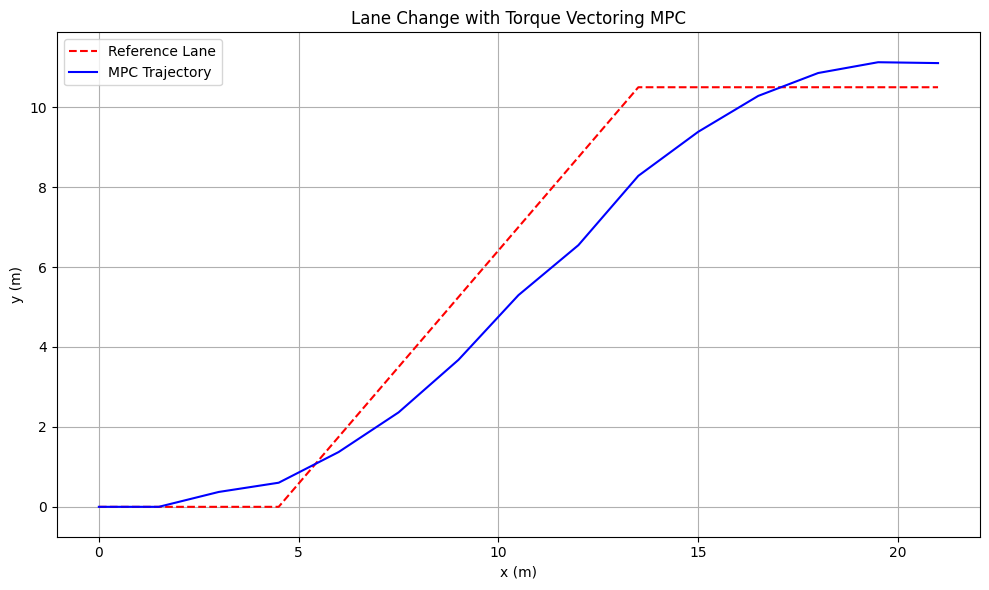

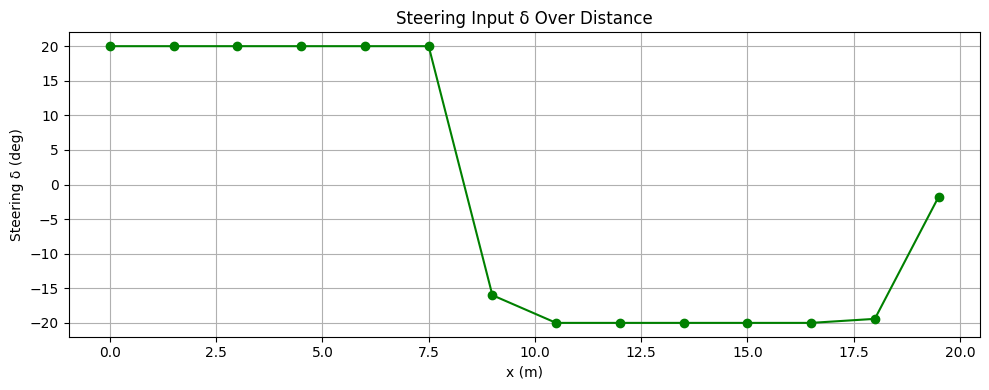

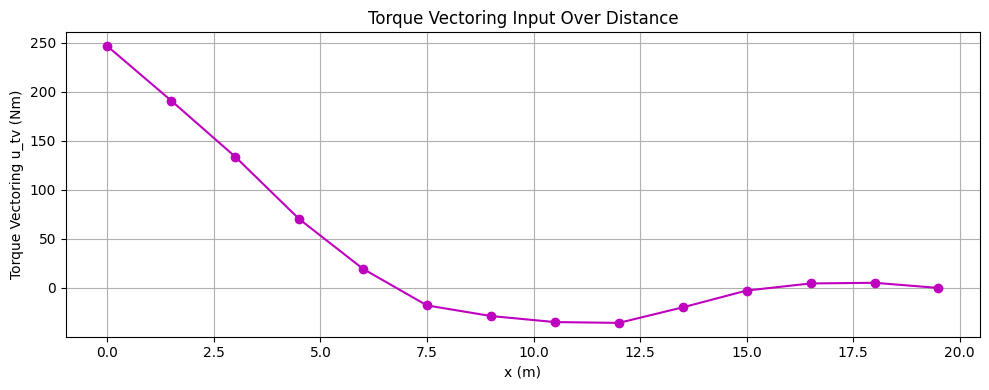

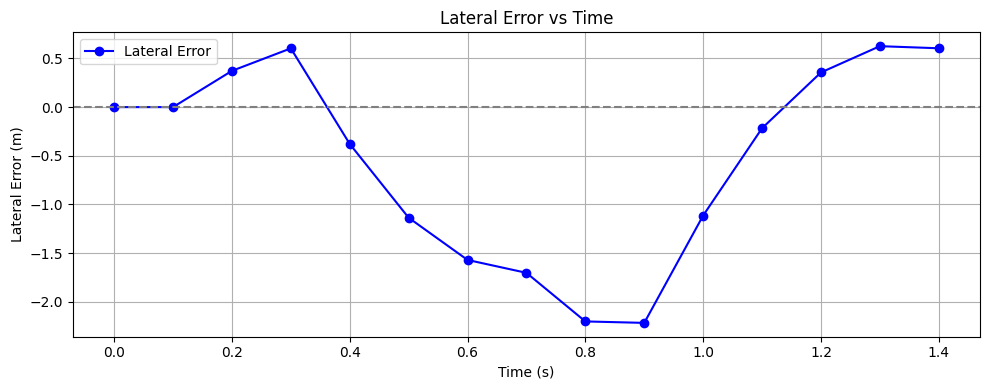

Average Absolute Lateral Error: 0.8734 meters


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# === Vehicle Parameters ===
N = 14
dt = 0.1
v_long = 15.0
a = 1.2
b = 1.3
m = 1500.0
Iz = 3000.0
Cf = 80000.0
Cr = 80000.0
delta_max = np.deg2rad(20)
w_delta = 0.1

# === Torque Vectoring Parameters ===
w_track = 1.6
K_tv = w_track / (2 * Iz)
u_tv_max = 5000.0
w_tv = 1e-6

# === Initial Conditions ===
y0 = 0.0
psi0 = 0.0
vy0 = 0.0
r0 = 0.0

# === Reference Trajectory ===
x_ref = np.linspace(0, N * dt * v_long, N + 1)
y_ref = np.zeros(N + 1)
hold_steps = 3
transition_length = 9.0
y_final = 10.5

for k in range(hold_steps, N + 1):
    dx = x_ref[k] - x_ref[hold_steps]
    if dx <= transition_length:
        y_ref[k] = (dx / transition_length) * y_final
    else:
        y_ref[k] = y_final

# === Optimization Variables ===
vy = cp.Variable(N + 1)
r = cp.Variable(N + 1)
y = cp.Variable(N + 1)
psi = cp.Variable(N + 1)
delta = cp.Variable(N)
u_tv = cp.Variable(N)

# === Linear Dynamics Coefficients ===
A11 = -(2 * Cf + 2 * Cr) / (m * v_long)
A12 = -v_long - (2 * Cf * a - 2 * Cr * b) / (m * v_long)
A21 = -(2 * Cf * a - 2 * Cr * b) / (Iz * v_long)
A22 = -(2 * Cf * a**2 + 2 * Cr * b**2) / (Iz * v_long)
B1 = 2 * Cf / m
B2 = 2 * Cf * a / Iz

# === Build Cost and Constraints ===
cost = 0
constraints = []

for k in range(N):

    cost += 2 * cp.square(y[k+1] - y_ref[k+1]) + w_delta * cp.square(delta[k]) + w_tv * cp.square(u_tv[k])
    r_ref = np.gradient(np.unwrap(np.arctan2(np.gradient(y_ref), np.gradient(x_ref))), dt)
    w_r = 0.1  # yaw rate tracking weight
    cost += w_r * cp.square(r[k+1] - r_ref[k+1])


    constraints += [vy[k+1] == vy[k] + dt * (A11 * vy[k] + A12 * r[k] + B1 * delta[k])]
    constraints += [r[k+1] == r[k] + dt * (A21 * vy[k] + A22 * r[k] + B2 * delta[k] + K_tv * u_tv[k])]
    constraints += [y[k+1] == y[k] + dt * (vy[k] + v_long * psi[k])]
    constraints += [psi[k+1] == psi[k] + dt * r[k]]
    constraints += [cp.abs(delta[k]) <= delta_max]
    constraints += [cp.abs(u_tv[k]) <= u_tv_max]

# Initial State
constraints += [vy[0] == vy0, r[0] == r0, y[0] == y0, psi[0] == psi0]

# === Solve MPC ===
problem = cp.Problem(cp.Minimize(cost), constraints)
problem.solve()

# === Plot Results ===
plt.figure(figsize=(10, 6))
plt.plot(x_ref, y_ref, 'r--', label='Reference Lane')
plt.plot(x_ref, y.value, 'b-', label='MPC Trajectory')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Lane Change with Torque Vectoring MPC')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Plot steering input
plt.figure(figsize=(10, 4))
plt.plot(x_ref[:-1], np.rad2deg(delta.value), 'g-o')
plt.xlabel('x (m)')
plt.ylabel('Steering δ (deg)')
plt.title('Steering Input δ Over Distance')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot torque vectoring input
plt.figure(figsize=(10, 4))
plt.plot(x_ref[:-1], u_tv.value, 'm-o')
plt.xlabel('x (m)')
plt.ylabel('Torque Vectoring u_tv (Nm)')
plt.title('Torque Vectoring Input Over Distance')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot lateral tracking error
lateral_error = y.value - y_ref
time = np.linspace(0, N * dt, N + 1)
plt.figure(figsize=(10, 4))
plt.plot(time, lateral_error, 'b-o', label='Lateral Error')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Lateral Error (m)')
plt.title('Lateral Error vs Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# === Compute Average Absolute Lateral Error ===
avg_abs_lateral_error = np.mean(np.abs(y.value - y_ref))
print(f"Average Absolute Lateral Error: {avg_abs_lateral_error:.4f} meters")



Total Steering Effort: 1.3708
Total Torque Vectoring Effort: 47077.3500


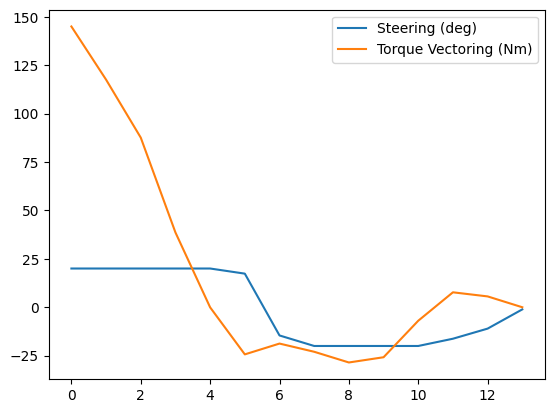

In [6]:
plt.plot(np.rad2deg(delta.value), label="Steering (deg)")
plt.plot(u_tv.value, label="Torque Vectoring (Nm)")
plt.legend()

total_steering_energy = np.sum(delta.value**2)
total_tv_energy = np.sum(u_tv.value**2)

print(f"Total Steering Effort: {total_steering_energy:.4f}")
print(f"Total Torque Vectoring Effort: {total_tv_energy:.4f}")

